In [663]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import pickle

# Set to typeface of report
plt.rcParams["font.family"] = "Times New Roman"

In [664]:
# Get address of where the repository is located on your computer.
# Will raise exception is you're in the wrong folder.
if not os.getcwd().endswith("02443-SimSolarEnergy\\code"):
    raise Exception("Change working directory to the code folder.")
repo_loc = os.getcwd()[ : -len("\\code")]

In [665]:
# Import solar data for 1 year
solar_data = pd.read_csv(repo_loc + "\\data\\solar_data_final\\solar_data.csv")
radiation = solar_data["Global Solar Data"].to_numpy() / 1000 # <- change unit to kWh

In [666]:
# Import energy consumption for 1 year for population of ALice Springs
file_prefix = repo_loc + "\\data\\power_data_from_ari\\Power_all_" 
suffixes = ["child_551",
            "senior_55",
            "adult1_289",
            "adult2_482",
            "adult3_458",
            "adult4_288"]
ext = ".csv"

In [667]:
# load all data (as lists)
all_demand_data = {}
for suffix in suffixes:
    with open(file_prefix + suffix + ext,'rb') as f:
        all_demand_data[suffix] = pickle.load(f)

In [668]:
# Change all data to numpy
all_demand_array = np.array([all_demand_data[s] for s in suffixes])
N, M = all_demand_array.shape
print(N, M)

6 52196


In [669]:
# Sum all data and multiply by 12
demand_all = np.sum(all_demand_array, axis=0) * 12
N = len(demand_all)
print(N)

52196


In [670]:
# Insert missing demand values
for i in range(143, 143 * 365, 143):
    demand_to_insert = (demand_all[i] + demand_all[i + 1]) / 2
    demand_all = np.insert(demand_all, i + 1, demand_to_insert)
N = len(demand_all)
print(N)

52560


In [671]:
# Does the sum of demand makes sense?
# Children use about 13k kWh and adults 16k kWh
# per year. Demographics from the bottom of
# the Markov model script.
c = (6606) * 13000
a = (3468 + 5778 + 5498 + 2731 + 658) * 16000
print("Ratio of actual demand to theoretical demand is %0.4f." % (sum(demand_all)/(a + c)))

Ratio of actual demand to theoretical demand is 1.0438.


In [672]:
# Decide parameters for solar farm
solar_farm_efficiency = 0.1801 # efficiency of the Jinko panel
yrly_demand = sum(demand_all)
yrly_supply_per_sqm = sum(radiation) * solar_farm_efficiency

# Print to check it out
print("The yearly demand is %0.0f kWh and the yearly supply per sq. m is %0.0f kWh." % (yrly_demand, yrly_supply_per_sqm))

# How many sq. m of panels do we need?
solar_farm_size = round(yrly_demand / yrly_supply_per_sqm)
print("We'd need about %0.0f sq. m of panels to meet supply." % solar_farm_size)



The yearly demand is 392480870 kWh and the yearly supply per sq. m is 24095 kWh.
We'd need about 16289 sq. m of panels to meet supply.


In [673]:
# Decide  battery parameters
battery_cap = 40000 # kW hours
rt_efficiency = 0.86 # for lithium-ion battery

In [674]:
# Init system performance stats
power_in_battery = np.zeros(N + 1)
power_in_battery[0] = 0.5 * battery_cap
supply_demand_balance = np.zeros(N)
supply_all = radiation * solar_farm_size * solar_farm_efficiency

# Loop through time periods
for t in range(N):
    supply = supply_all[t]
    demand = demand_all[t]
    
    if demand > supply:
        
        # Get difference
        deficit = demand - supply
        decharge_need = deficit / rt_efficiency
        
        # Find decharge amount
        if decharge_need > power_in_battery[t]:
            decharge_amount = power_in_battery[t]
        else:
            decharge_amount = decharge_need
            
        # Update states
        power_in_battery[t + 1] = power_in_battery[t] - decharge_amount
        supply_demand_balance[t] = decharge_amount * rt_efficiency - deficit
    
    elif demand < supply:
        
        # Get difference
        surplus = supply - demand
        
        # Find charge amount
        charge_amount = min(battery_cap - power_in_battery[t], surplus)
        
        # Update states
        power_in_battery[t + 1] = power_in_battery[t] + charge_amount
        supply_demand_balance[t] = surplus - charge_amount
    
    else:
        supply_demand_balance[t] = 0
        power_in_battery[t + 1] = power_in_battery[t]

In [675]:
print("Min/max power in battery is %0.1f, %0.1f." % (max(power_in_battery)/1000, min(power_in_battery)))
print("Min/max import/export is %0.2f, %0.2f." % (max(supply_demand_balance)/1000, min(supply_demand_balance)/1000))
print("Net import/export and battery storage is %0.2f, %0.2f, respectively." % (sum(supply_demand_balance)/1000, sum(power_in_battery)/1000))
print("Avg. import/export and energy storage is %0.2f, %0.2f, respectively." % (np.mean(supply_demand_balance)/1000, np.mean(power_in_battery)/1000))

Min/max power in battery is 40.0, 0.0.
Min/max import/export is 29.63, -14.45.
Net import/export and battery storage is -2131.52, 647211.91, respectively.
Avg. import/export and energy storage is -0.04, 12.31, respectively.


In [676]:
def plot(up, low, one_plot=False, save=False,legend=False):
    
    x = np.arange(1, N + 1)[up:low]
    
    if one_plot:
        plt.figure()
        plt.plot(x, demand_all[up:low], label="Demand")
        plt.plot(x, supply_all[up:low], label="Supply")
        plt.plot(x, power_in_battery[up:low], label="Stored")
        plt.plot(x, supply_demand_balance[up:low], label="Net export")
        if legend:
            plt.legend(fontsize=12)
        plt.xticks([(up + i) for i in range(0, 2 * 144 + 1, 36)],
                  ["00", "06", "12", "18", "00", "06", "12", "18", "00"],
                  fontsize=12)
        plt.xlabel("Time of day", fontsize=14)
        plt.yticks([i for i in range(-10000, 40001, 10000)],
                  ["%0.0f" % i for i in range(-10, 41, 10)],
                  fontsize=12)
        plt.ylabel("MWh", fontsize=14)
        
        
    else:
        fig = plt.figure(figsize=[12, 12])

        ax1 = plt.subplot(411)
        plt.plot(x, demand_all[up:low], label="Demand")
        plt.setp(ax1.get_xticklabels(), visible=False)
        plt.legend()

        ax2 = plt.subplot(412, sharex=ax1)
        plt.plot(x, supply_all[up:low], label="Supply")
        plt.setp(ax2.get_xticklabels(), visible=False)
        plt.legend()

        ax3 = plt.subplot(413, sharex=ax1)
        plt.plot(x, power_in_battery[up:low], label="Stored")
        plt.setp(ax3.get_xticklabels(), visible=False)
        plt.legend()

        ax4 = plt.subplot(414, sharex=ax1)
        plt.plot(x, supply_demand_balance[up:low], label="Net export")
        plt.legend()
    
    if save:
        plt.savefig(repo_loc + "\\figures\\" + save + ".png")

    plt.show()

In [677]:
[(144 + i) for i in range(0, 2*144 + 1, 36)]

[144, 180, 216, 252, 288, 324, 360, 396, 432]

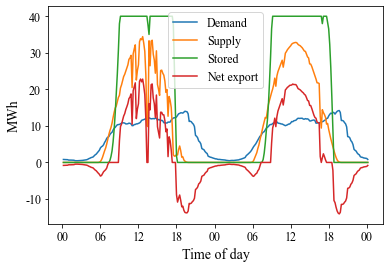

In [678]:
# 3 days over the summer
plot(144, 3 * 144 + 1, one_plot=True, legend=True, save="results_summer")

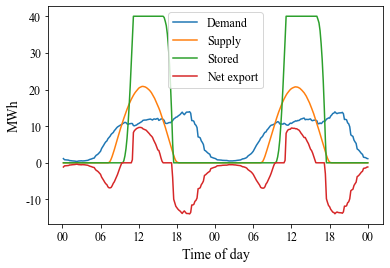

In [679]:
# 3 days over the winter
plot(170 * 144, 172 * 144, one_plot=True, legend=True, save="results_winter")